# Limits of Spectrogram Modeling

While spectrograms are easily the most convenient and understandable way for humans to visualize a piece of music, they do have a very important limit within the realm of MSS. 

To demonstrate this watch how by converting to a spectrogram, with the in theory "perfect" mask for a given audio signal to create source separation, still results in noticable problems in the audio. 

In [1]:
import numpy as np
import librosa
import musdb
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
import audio_processing as ap
sys.path.append('../')

In [2]:
mus = musdb.DB(download=True)
track = mus[21]
track.name

'Clara Berry And Wooldog - Waltz For My Victims'

In [3]:
sr = track.rate
mix, drums, bass, other, vocals = [librosa.to_mono(audio.T) for audio in track.stems] # musdb parses data in transposed format to most audio objects.
ipd.display(ipd.Audio(mix, rate=sr))

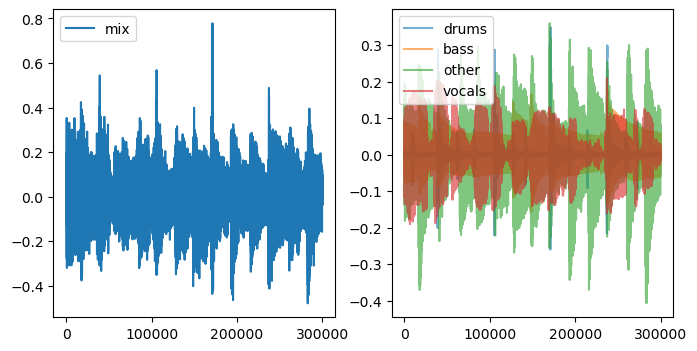

In [4]:
ap.plot_song_sources(track)

Say we just want to isolate the vocals of song, we can see exactly what this section looks like in the spectrogram.

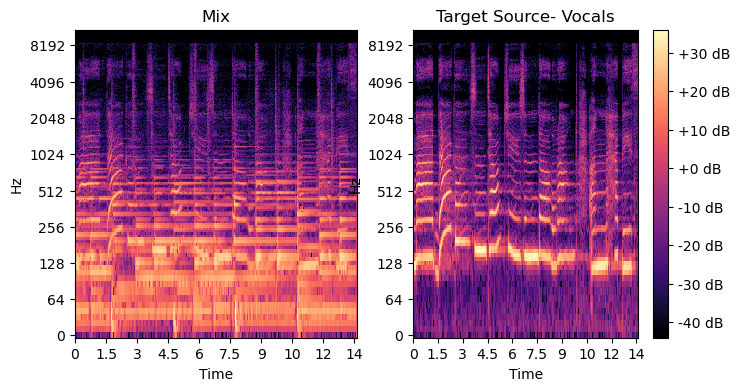

In [5]:
fig,axes = plt.subplots(1,2, figsize=(8,4))
img,mix_representation,x_m = ap.create_spectrogram(mix,axes[0])
axes[0].set_title("Mix")
voc_img,voc_representation,x_v = ap.create_spectrogram(vocals,axes[1])
axes[1].set_title("Target Source- Vocals")
fig.colorbar(voc_img, format="%+2.0f dB")

In this case we can create a perfect mask, by just using the spectrogram for the vocals and applying it to the mix. Should be very straight forward.

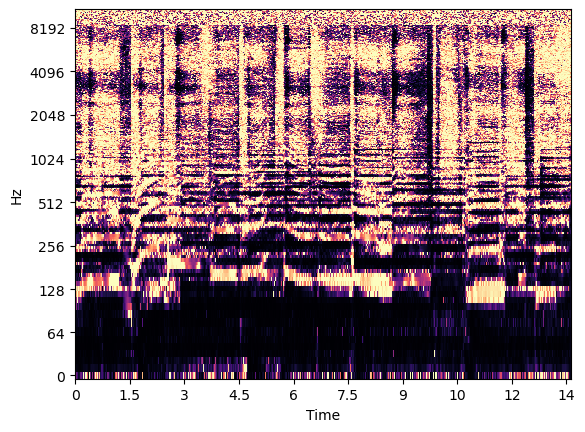

In [6]:
mask = voc_representation / np.maximum(voc_representation, mix_representation) # + 1e-8
librosa.display.specshow(mask, y_axis='log', x_axis='time',cmap='magma')

Just looking at our resulting spectrogram theres already a pretty apparent difference in our two spectrograms. The good news is most of the missing audio is 30db or less which to give context, 30db is about the loudness of a soft whisper. 

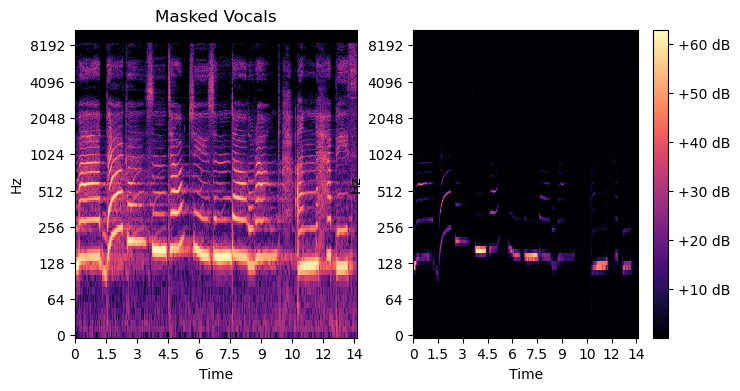

In [10]:
fig,axes = plt.subplots(1,2, figsize=(8,4))
voc_img,_,_ = create_spectrogram(vocals,axes[0])
axes[0].set_title("Actual Vocals")
axes[1].set_title("Masked Vocals")

masked_voc = x_m * mask

mask_img =librosa.display.specshow(np.abs(masked_voc), y_axis='log', x_axis='time',cmap='magma',ax=axes[1])
fig.colorbar(mask_img, format="%+2.0f dB")

Okay, but how does the masked audio sound? That is the important part of our audio separation, so is the difference very apparent?

In [8]:
masked_voc_signal = librosa.istft(masked_voc,n_fft=2048, hop_length=2048 //4, window='hann', center=True)
print('True Vocal Stem')
ipd.display(ipd.Audio(vocals, rate=sr))
print('Estimated Vocal Stem')
ipd.display(ipd.Audio(masked_voc_signal, rate=sr))


True Vocal Stem


Estimated Vocal Stem


### Reults

The results are somewhat surprisingly nearly identical in overall sound. But, there is a very noticable change in the two, the voice seems to sound robotic/distorted throughout the audio and this is for a very good reason. The reconstructed audio does not take the phase of the music into account. So the sine wave will jump discontinuously to different positions which creates the effect of distortion or robotic sound (aka square waves). 

The conclusion of this experiment reveals the hidden limitation of spectrogram based methods, that due to its lack of phase reproducability, the estimated sources have an upper limit on how accurate they can sound.